In [4]:
from sklearn.model_selection import train_test_split
from scripts.data_preprocessing import load_data, drop_high_correlated_features, scale_features, calculate_class_weights
from scripts.models import get_svm, get_random_forest, get_gradient_boosting, get_knn, get_log_reg
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd

In [5]:
SEED = 5296

In [6]:
X, y = load_data()

X = drop_high_correlated_features(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train, X_test = scale_features(X_train, X_test)

y_train = y_train.idxmax(axis=1)
y_test = y_test.idxmax(axis=1)

class_weights = calculate_class_weights(y_train)
print("Class weights:", class_weights)

Class weights: {'Bumps': np.float64(0.7060964513193813), 'Dirtiness': np.float64(4.717325227963526), 'K_Scratch': np.float64(0.6821978021978022), 'Other_Faults': np.float64(0.4136460554371002), 'Pastry': np.float64(1.8173302107728337), 'Stains': np.float64(3.8226600985221677), 'Z_Scratch': np.float64(1.4780952380952381)}


In [7]:
settings = {
    "SVM" : {
        "kernel": "rbf",
        "C": 1.0,
        "class_weight": "balanced"
    },
    "Random Forest": {
        "n_estimators": 200,
        "max_depth": 10,
        "class_weight": "balanced"
    },
    "Gradient Boosting": {
        "loss": "log_loss",
        "learning_rate": 0.1,
        "n_estimators": 200,
        "max_depth": 10,
        "class_weight": "balanced"
    },
    "KNN": {
        "n_neighbors": 5
    },
    "Logistic Regression": {
        "max_iter": 1000,
        "class_weight": "balanced"
    }
}

models = {
    "SVM": get_svm(
        settings["SVM"]["kernel"],
        settings["SVM"]["C"],
        settings["SVM"]["class_weight"],
        SEED
    ),
    "Random Forest": get_random_forest(
        settings["Random Forest"]["n_estimators"],
        settings["Random Forest"]["max_depth"],
        settings["Random Forest"]["class_weight"],
        SEED
    ),
    "Gradient Boosting": get_gradient_boosting(
        settings["Gradient Boosting"]["loss"],
        settings["Gradient Boosting"]["learning_rate"],
        settings["Gradient Boosting"]["n_estimators"],
        settings["Gradient Boosting"]["max_depth"],
        SEED
    ),
    "KNN": get_knn(
        settings["KNN"]["n_neighbors"]
    ),
    "Logistic Regression": get_log_reg(
        settings["Logistic Regression"]["max_iter"],
        settings["Logistic Regression"]["class_weight"],
        SEED
    )
}

In [8]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = {"Baseline": {"Model": model, "predictions": y_pred, "Metrics": {"Accuracy": acc, "Precision": precision, "Recall": recall, "F1": f1}}}
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))


=== SVM ===
              precision    recall  f1-score   support

       Bumps       0.55      0.55      0.55        88
   Dirtiness       0.35      1.00      0.52         8
   K_Scratch       0.95      0.91      0.93        66
Other_Faults       0.70      0.36      0.48       137
      Pastry       0.52      0.92      0.67        36
      Stains       0.73      0.79      0.76        14
   Z_Scratch       0.51      0.85      0.64        40

    accuracy                           0.63       389
   macro avg       0.62      0.77      0.65       389
weighted avg       0.67      0.63      0.62       389


=== Random Forest ===
              precision    recall  f1-score   support

       Bumps       0.58      0.68      0.63        88
   Dirtiness       0.50      0.62      0.56         8
   K_Scratch       0.98      0.91      0.94        66
Other_Faults       0.68      0.61      0.64       137
      Pastry       0.63      0.72      0.68        36
      Stains       0.85      0.79      0.8

In [9]:
to_dataframe = {name: results[name]['Baseline']['Metrics'] for name in results}
baseline_results = pd.DataFrame(to_dataframe)

baseline_results

,SVM,Random Forest,Gradient Boosting,KNN,Logistic Regression
Accuracy,0.627249,0.714653,0.740360,0.634961,0.593830
Precision,0.668619,0.725595,0.747899,0.637961,0.646829
Recall,0.627249,0.714653,0.740360,0.634961,0.593830
F1,0.616209,0.717852,0.742469,0.634717,0.585364


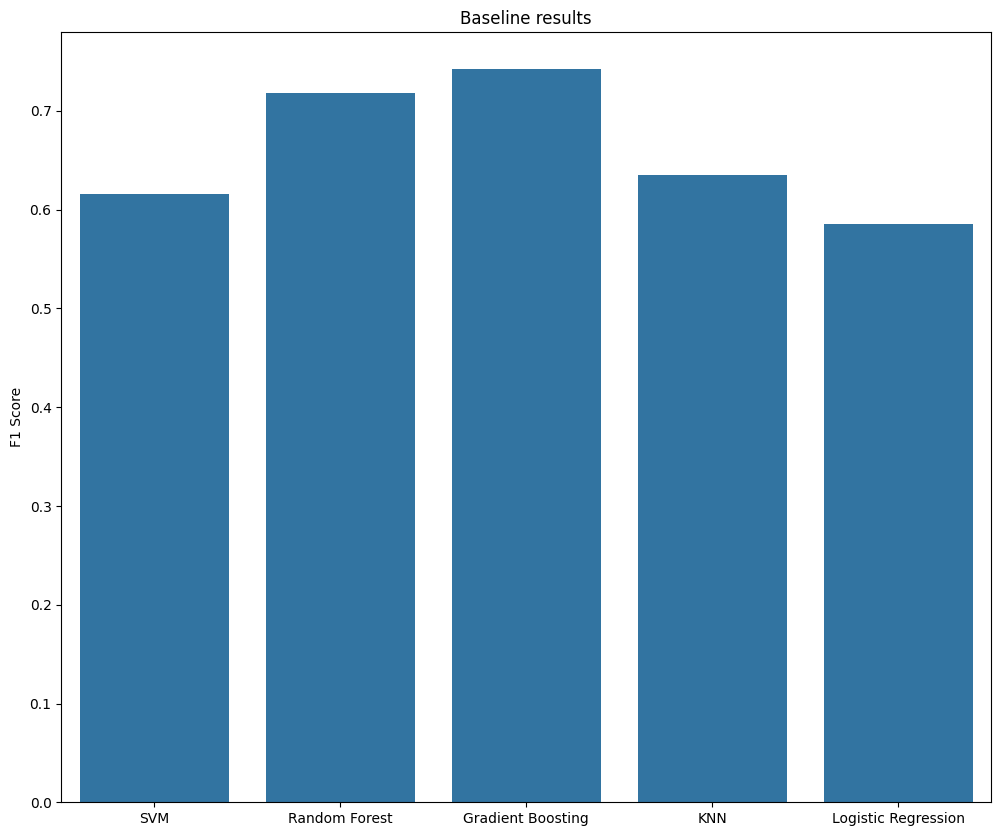

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,10))
sns.barplot(baseline_results.T["F1"])
plt.title("Baseline results")
plt.ylabel("F1 Score")
plt.savefig("figs/baseline_results.png")
plt.show()

In [10]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
import numpy as np

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted'),
    'f1_weighted': make_scorer(f1_score, average='weighted')
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, model in models.items():
    print(f"\n=== Training {name} with 5-fold cross-validation ===")
    
    cv_results = cross_validate(
        model, X_train, y_train, 
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        return_estimator=True,
        n_jobs=-1
    )
    
    results[name] = {
        'CrossValidation': {
            'model': model,
            'cv_results': {
                'test_accuracy': cv_results['test_accuracy'],
                'test_precision': cv_results['test_precision_weighted'],
                'test_recall': cv_results['test_recall_weighted'],
                'test_f1': cv_results['test_f1_weighted'],
                'estimators': cv_results['estimator']
            }
        }
    }
    
    print(f"\n{name} Cross-Validation Results (5-fold):")
    print(f"Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
    print(f"Precision: {np.mean(cv_results['test_precision_weighted']):.4f}")
    print(f"Recall: {np.mean(cv_results['test_recall_weighted']):.4f}")
    print(f"F1 Score: {np.mean(cv_results['test_f1_weighted']):.4f}")



=== Training SVM with 5-fold cross-validation ===

SVM Cross-Validation Results (5-fold):
Accuracy: 0.6443
Precision: 0.7090
Recall: 0.6443
F1 Score: 0.6382

=== Training Random Forest with 5-fold cross-validation ===

Random Forest Cross-Validation Results (5-fold):
Accuracy: 0.7307
Precision: 0.7397
Recall: 0.7307
F1 Score: 0.7322

=== Training Gradient Boosting with 5-fold cross-validation ===

Gradient Boosting Cross-Validation Results (5-fold):
Accuracy: 0.7622
Precision: 0.7651
Recall: 0.7622
F1 Score: 0.7606

=== Training KNN with 5-fold cross-validation ===

KNN Cross-Validation Results (5-fold):
Accuracy: 0.6708
Precision: 0.6780
Recall: 0.6708
F1 Score: 0.6707

=== Training Logistic Regression with 5-fold cross-validation ===

Logistic Regression Cross-Validation Results (5-fold):
Accuracy: 0.6095
Precision: 0.6686
Recall: 0.6095
F1 Score: 0.5982


In [11]:
best_results = {}

for name in models.keys():
    cv_results = results[name]["CrossValidation"]['cv_results']
    
    metrics = {}
    for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']:
        max = np.max(cv_results[metric])
        metrics[metric] = max

    best_results[name] = metrics

In [12]:
cv_results = pd.DataFrame(best_results)

cv_results

,SVM,Random Forest,Gradient Boosting,KNN,Logistic Regression
test_accuracy,0.658065,0.745981,0.780645,0.693548,0.638710
test_precision,0.728026,0.752808,0.788844,0.702462,0.717222
test_recall,0.658065,0.745981,0.780645,0.693548,0.638710
test_f1,0.659238,0.747225,0.782494,0.695922,0.639590


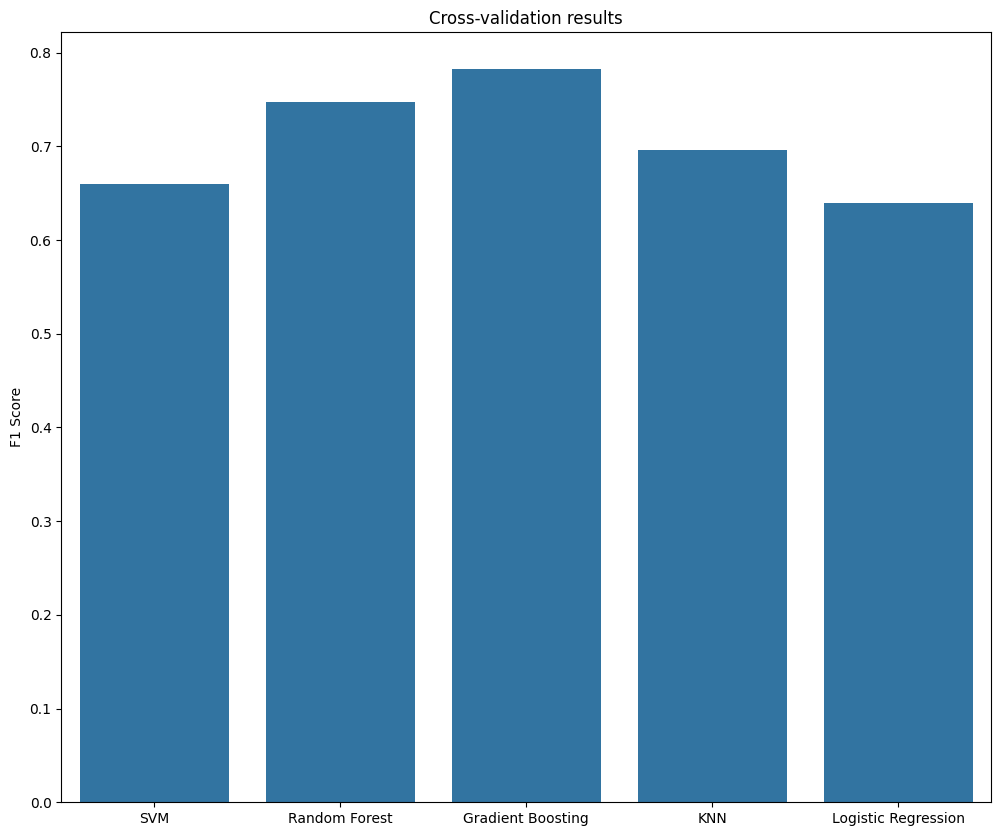

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,10))
sns.barplot(cv_results.T['test_f1'])
plt.title("Cross-validation results")
plt.ylabel("F1 Score")
plt.savefig("figs/cv_results.png")
plt.show()